# Analizing Floddings in Colombia Using Vector Data

The idea behind this exercise was to identify the areas most likely to be affected by flodding events in Colombia. The following geographic data was used to carry out the analisys:

- Colombian Departments
- Municipalities
- Cities
- Rivers
- Watersheds
- Rainfall data

This workshop was initially solved using conventional Desktop GIS tools (ArcGIS, QGIS). The idea now is to solve the proposed questions by using Python libraries.


### Importing Layers

The first step will be importing the required layers as GeoDataFrames, checking their assigned coordinate reference systems or assigned the correspondent one for those layers that don't have one yet

In [90]:
import pathlib
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = 'data'

In [3]:
def open_geodataframe(df_path: str) -> gpd.GeoDataFrame:
  if not os.path.exists(df_path):
    raise FileNotFoundError
  return gpd.read_file(df_path)

def print_crs(df: gpd.GeoDataFrame) -> None:
  print(df.crs)

def geometry_type(df: gpd.GeoDataFrame, geom_col: str = 'geometry') -> None:
   print(type(df.at[0, geom_col]))

In [4]:
departments_df = open_geodataframe('data/limite_departamental.shp')
municipalities_df = open_geodataframe('data/municipios.shp')
cities_df = open_geodataframe('data/cabeceras.shp')
rivers_df = open_geodataframe('data/rios_colombia.shp')
watersheds_df = open_geodataframe('data/cuencas_hidrograficas.shp')
rainfall_df = open_geodataframe('data/precipitacion2008.shp')


In [5]:
departments_df.head()

,ID_ESPACIA,AREA_OFICI,NOMBRE_DPT,geometry
0,11,1605.0,BOGOTÁ,"POLYGON ((1000872.357 1025835.467, 1000893.001..."
1,13,26383.0,BOLÍVAR,"POLYGON ((871110.508 1686327.455, 871168.526 1..."
2,15,23189.0,BOYACÁ,"POLYGON ((1211950.987 1270917.760, 1212059.177..."
3,17,7888.0,CALDAS,"POLYGON ((934334.460 1129841.825, 934457.415 1..."
4,18,88965.0,CAQUETÁ,"POLYGON ((921349.237 815160.187, 921349.237 81..."


In [6]:
print_crs(municipalities_df)

PROJCS["GAUSS_BTA_MAGNA",GEOGCS["CGS_SIRGAS",DATUM["CGS_SIRGAS",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4.596200417],PARAMETER["central_meridian",-74.077507917],PARAMETER["scale_factor",1],PARAMETER["false_easting",1000000],PARAMETER["false_northing",1000000],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [7]:
geometry_type(municipalities_df)

<class 'shapely.geometry.polygon.Polygon'>


In [37]:
spatial_df_list = [departments_df, municipalities_df, cities_df, rivers_df, watersheds_df, rainfall_df]

for df in spatial_df_list:
  df.to_crs(inplace=True, crs=3116)

#### 1. Identify which cities are located within a 500 meters distance from the rivers

To solve this, it was necessary to create first a buffer of 500 meters was created for the rivers layer and those were later stored in  new column called `buffer_500`

In [10]:
rivers_df['buffer_500'] = rivers_df['geometry'].buffer(500)
rivers_df.head()

,ID_ST,NOMBRE,SHAPE_LEN,geometry,buffer_500
0,940000000,RIO HUMEA,93365.956974,"LINESTRING (1078950.473 1001228.764, 1079127.5...","POLYGON ((1079233.687 1001650.668, 1079476.539..."
1,940000021,RIO GUACAVIA,81075.676229,"LINESTRING (1049294.641 977511.108, 1049472.38...","POLYGON ((1049762.591 977791.581, 1049795.315 ..."
2,940000022,RIO GAZAMUMO,31478.288849,"LINESTRING (1063322.524 996229.891, 1063753.26...","POLYGON ((1063988.423 996441.575, 1064002.651 ..."
3,940000033,RIO GAZAUNTA,23665.770795,"LINESTRING (1068244.477 999502.351, 1068627.71...","POLYGON ((1068322.681 1000175.200, 1068383.260..."
4,940000037,RIO GUAJARAY,17085.109963,"LINESTRING (1061269.465 980516.444, 1061596.95...","POLYGON ((1062010.879 980313.607, 1062032.351 ..."


/Users/cristianmurillo/miniconda3/envs/geo/lib/python3.8/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot: >

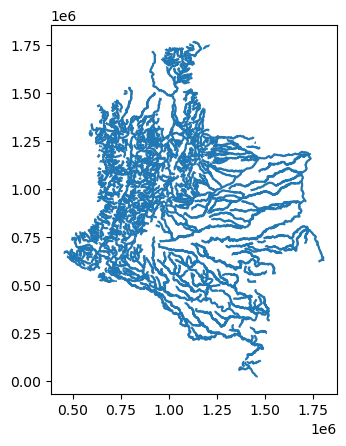

In [11]:
rivers_df_b = rivers_df
rivers_df_b.reset_index()
ax = rivers_df.plot(column='buffer_500', color='#cccccc')
rivers_df_b.plot(ax=ax)

In [12]:
type(rivers_df.at[0, 'geometry'])

shapely.geometry.linestring.LineString

In [35]:
cities_df.head()

,CODIGO,NOMBRE,x,y,geometry
0,05001,MEDELLIN,834089.038291,1.185020e+06,POINT (834089.038 1185020.327)
1,05002,ABEJORRAL,849454.114897,1.131881e+06,POINT (849454.115 1131881.255)
2,05004,ABRIAQUI,778888.519475,1.225041e+06,POINT (778888.519 1225040.994)
3,05021,ALEJANDRIA,881708.482127,1.195965e+06,POINT (881708.482 1195964.586)
4,05030,AMAGA,818512.585558,1.159621e+06,POINT (818512.586 1159621.141)


In [13]:
cities_df = cities_df.to_crs(epsg=3116)
cities_df.crs

<Derived Projected CRS: EPSG:3116>
Name: MAGNA-SIRGAS / Colombia Bogota zone
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore between 1°30'W and 1°30'E of Bogota (75°35'W and 72°35'W of Greenwich).
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia MAGNA Bogota zone
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
rivers_df = rivers_df.to_crs(epsg=3116)
rivers_df['geometry'].crs

<Derived Projected CRS: EPSG:3116>
Name: MAGNA-SIRGAS / Colombia Bogota zone
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore between 1°30'W and 1°30'E of Bogota (75°35'W and 72°35'W of Greenwich).
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia MAGNA Bogota zone
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [15]:
rivers_df['buffer_500'] = rivers_df['buffer_500'].to_crs(epsg=3116)


In [16]:
rivers_df['buffer_500'].crs

<Derived Projected CRS: EPSG:3116>
Name: MAGNA-SIRGAS / Colombia Bogota zone
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore between 1°30'W and 1°30'E of Bogota (75°35'W and 72°35'W of Greenwich).
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia MAGNA Bogota zone
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [25]:
rivers_df.columns

Index(['ID_ST', 'NOMBRE', 'SHAPE_LEN', 'geometry', 'buffer_500'], dtype='object')

In [28]:
rivers_buffer_500 = rivers_df[['ID_ST', 'NOMBRE', 'SHAPE_LEN', 'buffer_500']]
rivers_buffer_500 = rivers_buffer_500.reset_index()
rivers_buffer_500 = rivers_buffer_500.set_geometry('buffer_500')

cities_in_buffer_500 = gpd.sjoin(left_df=cities_df, right_df=rivers_buffer_500, how='inner', predicate='within')
cities_in_buffer_500.head()

,CODIGO,NOMBRE_left,x,y,geometry,index_right,index,ID_ST,NOMBRE_right,SHAPE_LEN
8,05038,ANGOSTURA,860823.105534,1.251320e+06,POINT (860826.404 1251327.080),719,719,940011749,RIO DOLORES,25119.131818
15,05059,ARMENIA,809679.972899,1.168499e+06,POINT (809682.538 1168506.489),595,595,940010471,RIO AMAGA,23867.088206
16,05079,BARBOSA,860699.226614,1.202649e+06,POINT (860702.158 1202655.665),571,571,940010244,RIO MEDELLIN,86668.084547
26,05129,CALDAS,827385.700909,1.164020e+06,POINT (827388.269 1164027.160),571,571,940010244,RIO MEDELLIN,86668.084547
85,05631,SABANETA,828512.462849,1.170655e+06,POINT (828515.084 1170661.650),571,571,940010244,RIO MEDELLIN,86668.084547


In [29]:
cities_in_buffer_500.columns

Index(['CODIGO', 'NOMBRE_left', 'x', 'y', 'geometry', 'index_right', 'index',
       'ID_ST', 'NOMBRE_right', 'SHAPE_LEN'],
      dtype='object')

In [30]:
columns = {
    'CODIGO': 'CITY_CODE', 
    'NOMBRE_left': 'NAME', 
    'x': 'X', 
    'y': 'Y', 
    'geometry': 'geometry', 
    'ID_ST': 'RIVER_ID', 
    'NOMBRE_right': 'RIVER'
}

In [31]:
# select and rename resulting columns
cities_in_buffer_500 = cities_in_buffer_500[['CODIGO', 'NOMBRE_left', 'x', 'y', 'geometry', 'ID_ST', 'NOMBRE_right']]
cities_in_buffer_500.rename(columns=columns, inplace=True)
cities_in_buffer_500.head()

,CITY_CODE,NAME,X,Y,geometry,RIVER_ID,RIVER
8,05038,ANGOSTURA,860823.105534,1.251320e+06,POINT (860826.404 1251327.080),940011749,RIO DOLORES
15,05059,ARMENIA,809679.972899,1.168499e+06,POINT (809682.538 1168506.489),940010471,RIO AMAGA
16,05079,BARBOSA,860699.226614,1.202649e+06,POINT (860702.158 1202655.665),940010244,RIO MEDELLIN
26,05129,CALDAS,827385.700909,1.164020e+06,POINT (827388.269 1164027.160),940010244,RIO MEDELLIN
85,05631,SABANETA,828512.462849,1.170655e+06,POINT (828515.084 1170661.650),940010244,RIO MEDELLIN


In [35]:
print(f'A total of {len(cities_in_buffer_500)} out of {len(cities_df)} are located within 500 meters of a river.')

A total of 88 out of 1080 are located within 500 meters of a river.


In [43]:
cities_antioquia = cities_in_buffer_500[cities_in_buffer_500['CITY_CODE'].str.startswith('05')]
cities_antioquia.head()

,CITY_CODE,NAME,X,Y,geometry,RIVER_ID,RIVER
8,05038,ANGOSTURA,860823.105534,1.251320e+06,POINT (860826.404 1251327.080),940011749,RIO DOLORES
15,05059,ARMENIA,809679.972899,1.168499e+06,POINT (809682.538 1168506.489),940010471,RIO AMAGA
16,05079,BARBOSA,860699.226614,1.202649e+06,POINT (860702.158 1202655.665),940010244,RIO MEDELLIN
26,05129,CALDAS,827385.700909,1.164020e+06,POINT (827388.269 1164027.160),940010244,RIO MEDELLIN
85,05631,SABANETA,828512.462849,1.170655e+06,POINT (828515.084 1170661.650),940010244,RIO MEDELLIN


#### 2. Identify the watershed with the highest number of affected cities because of flooding events

To solve this question, the affected cities obtained in the previous question were used to perform a spatial join together with the watersheds dataframe. The idea is to identify to which watershed each city belongs to, and then group them based on such watershed. Finally, the group with the highest value is considered to represent the watershed where the most affected cities is located in.

In [44]:
affected_cities = cities_in_buffer_500.copy()
cities_watershed = affected_cities.sjoin(df=watersheds_df, predicate='within')
cities_watershed.head()

,CITY_CODE,NAME,X,Y,geometry,RIVER_ID,RIVER,index_right,CODIGO,CUENCA,ANO
8,05038,ANGOSTURA,860823.105534,1.251320e+06,POINT (860826.404 1251327.080),940011749,RIO DOLORES,28,10,Río Nechi,2002
16,05079,BARBOSA,860699.226614,1.202649e+06,POINT (860702.158 1202655.665),940010244,RIO MEDELLIN,28,10,Río Nechi,2002
26,05129,CALDAS,827385.700909,1.164020e+06,POINT (827388.269 1164027.160),940010244,RIO MEDELLIN,28,10,Río Nechi,2002
85,05631,SABANETA,828512.462849,1.170655e+06,POINT (828515.084 1170661.650),940010244,RIO MEDELLIN,28,10,Río Nechi,2002
73,05495,NECHI,918527.606341,1.382818e+06,POINT (918529.057 1382823.180),940018103,RIO CAUCA,28,10,Río Nechi,2002


In [46]:
cities_watershed.columns

Index(['CITY_CODE', 'NAME', 'X', 'Y', 'geometry', 'RIVER_ID', 'RIVER',
       'index_right', 'CODIGO', 'CUENCA', 'ANO'],
      dtype='object')

In [47]:
cities_watershed = cities_watershed[['CITY_CODE', 'NAME', 'X', 'Y', 'geometry', 'RIVER_ID', 'RIVER', 'CODIGO', 'CUENCA']]
cities_watershed = cities_watershed.rename(columns={'CODIGO': 'WATERSHED_ID', 'CUENCA': 'WATERSHED'})
cities_watershed.head()

,CITY_CODE,NAME,X,Y,geometry,RIVER_ID,RIVER,WATERSHED_ID,WATERSHED
8,05038,ANGOSTURA,860823.105534,1.251320e+06,POINT (860826.404 1251327.080),940011749,RIO DOLORES,10,Río Nechi
16,05079,BARBOSA,860699.226614,1.202649e+06,POINT (860702.158 1202655.665),940010244,RIO MEDELLIN,10,Río Nechi
26,05129,CALDAS,827385.700909,1.164020e+06,POINT (827388.269 1164027.160),940010244,RIO MEDELLIN,10,Río Nechi
85,05631,SABANETA,828512.462849,1.170655e+06,POINT (828515.084 1170661.650),940010244,RIO MEDELLIN,10,Río Nechi
73,05495,NECHI,918527.606341,1.382818e+06,POINT (918529.057 1382823.180),940018103,RIO CAUCA,10,Río Nechi


In [49]:
cities_watershed.columns

Index(['CITY_CODE', 'NAME', 'X', 'Y', 'geometry', 'RIVER_ID', 'RIVER',
       'WATERSHED_ID', 'WATERSHED'],
      dtype='object')

In [66]:
cities_watershed_group = cities_watershed.groupby(by='WATERSHED_ID')[['WATERSHED_ID', 'WATERSHED']].size()
cities_watershed_group = cities_watershed_group.sort_values(ascending=False).reset_index(name='count')
cities_watershed_group


,WATERSHED_ID,count
0,1,16
1,3,13
2,7,11
3,4,8
4,10,6
5,40,5
6,21,4
7,2,3
8,37,3
9,8,3


In [74]:
watersheds_df[['CODIGO', 'CUENCA']]

,CODIGO,CUENCA
0,39,Alto Patía
1,45,Río Baudó - Directos
2,38,Río Mira-Guiza
3,42,Río Micay
4,41,Río Sanguianga - Patía Norte
5,40,Bajo Patía
6,43,Río Coyanero - Dagua
7,28,Bajo Guaviare
8,44,Río San Juan
9,15,Norte Sierra Nevada de Santa Marta


In [93]:
cities_watershed_result = cities_watershed_group.copy()
# perform regular join to get the watershed's name
cities_watershed_result['CODIGO'] = cities_watershed_result['WATERSHED_ID']
cities_watershed_join = cities_watershed_result.set_index('CODIGO').join(
    other=watersheds_df.set_index('CODIGO'), on='CODIGO', lsuffix='_caller', rsuffix='_other')
cities_watershed_join = cities_watershed_join[['WATERSHED_ID', 'count', 'CUENCA', 'geometry']]
cities_watershed_join.head()




,WATERSHED_ID,count,CUENCA,geometry
CODIGO,,,,
1,1,16,Alto Magdalena,"POLYGON ((1002382.984 990803.749, 1001594.113 ..."
3,3,13,Medio Magdalena,"POLYGON ((833461.496 1162371.570, 833093.683 1..."
7,7,11,Alto Cauca,"POLYGON ((853175.679 1011712.426, 853123.204 1..."
4,4,8,Río Sogamoso,"POLYGON ((1125107.536 1276535.627, 1125307.502..."
4,4,8,Río Sogamoso,"POLYGON ((683612.617 638557.110, 683688.697 63..."


In [94]:
cities_watershed_join =  cities_watershed_join.reset_index()
cities_watershed_join.head()

,CODIGO,WATERSHED_ID,count,CUENCA,geometry
0,1,1,16,Alto Magdalena,"POLYGON ((1002382.984 990803.749, 1001594.113 ..."
1,3,3,13,Medio Magdalena,"POLYGON ((833461.496 1162371.570, 833093.683 1..."
2,7,7,11,Alto Cauca,"POLYGON ((853175.679 1011712.426, 853123.204 1..."
3,4,4,8,Río Sogamoso,"POLYGON ((1125107.536 1276535.627, 1125307.502..."
4,4,4,8,Río Sogamoso,"POLYGON ((683612.617 638557.110, 683688.697 63..."


In [83]:
cities_watershed_join.columns

Index(['level_0', 'index', 'WATERSHED_ID', 'count', 'CUENCA', 'geometry'], dtype='object')

In [95]:
cities_watershed_join = cities_watershed_join[['WATERSHED_ID', 'count', 'CUENCA', 'geometry']]
cities_watershed_join.head()

,WATERSHED_ID,count,CUENCA,geometry
0,1,16,Alto Magdalena,"POLYGON ((1002382.984 990803.749, 1001594.113 ..."
1,3,13,Medio Magdalena,"POLYGON ((833461.496 1162371.570, 833093.683 1..."
2,7,11,Alto Cauca,"POLYGON ((853175.679 1011712.426, 853123.204 1..."
3,4,8,Río Sogamoso,"POLYGON ((1125107.536 1276535.627, 1125307.502..."
4,4,8,Río Sogamoso,"POLYGON ((683612.617 638557.110, 683688.697 63..."


In [141]:
max_cities  = int(cities_watershed_join['count'].max())
watershed_max = cities_watershed_join[cities_watershed_join['count'] == max_cities]
watershed_max = watershed_max[['WATERSHED_ID', 'count', 'CUENCA']]
watershed_ids = watershed_max['WATERSHED_ID'].to_list()
watershed = watersheds_df[watersheds_df['CODIGO'].isin(watershed_ids)]
watershed

,CODIGO,CUENCA,ANO,geometry
26,1,Alto Magdalena,2002,"POLYGON ((1002382.984 990803.749, 1001594.113 ..."


In [128]:
watershed_max['geometry']

0    POLYGON ((1002382.984 990803.749, 1001594.113 ...
Name: geometry, dtype: geometry

In [131]:
cities_watershed_max = cities_watershed[cities_watershed['geometry'].intersects(watershed_max['geometry'][0])]
cities_watershed_max.head()

,CITY_CODE,NAME,X,Y,geometry,RIVER_ID,RIVER,WATERSHED_ID,WATERSHED
367,19355,INZA,776512.091458,7.713780e+05,POINT (776504.139 771386.633),940002120,RIO ULLUCOS,1,Alto Magdalena
376,19517,PAEZ,786547.136382,7.846396e+05,POINT (786538.989 784648.561),940008084,RIO PAEZ,1,Alto Magdalena
609,41797,TESALIA,815447.857464,7.635792e+05,POINT (815440.303 763588.608),940008084,RIO PAEZ,1,Alto Magdalena
447,25086,BELTRAN,924662.094644,1.021153e+06,POINT (924661.830 1021154.924),940016470,RIO MAGDALENA,1,Alto Magdalena
540,25815,TOCAIMA,935724.880447,9.824373e+05,POINT (935722.801 982438.194),940009107,RIO BOGOTA,1,Alto Magdalena


In [188]:
watershed['geometry'].total_bounds


array([ 715819.70581619,  664028.85969816, 1002382.9842912 ,
       1085377.93989857])

In [189]:
xmin, ymin, xmax, ymax = watershed['geometry'].total_bounds
print(xmin, ymin, xmax, ymax)


715819.70581619 664028.8596981603 1002382.9842912019 1085377.9398985705


In [228]:
buffers_region = rivers_buffer_500[rivers_buffer_500.intersects(watershed['geometry'].iloc[0])]
rivers_region = rivers_df[rivers_df.intersects(watershed['geometry'].iloc[0])]
buffers_region = buffers_region.rename(columns={'buffer_500': 'geometry'}).set_geometry('geometry')


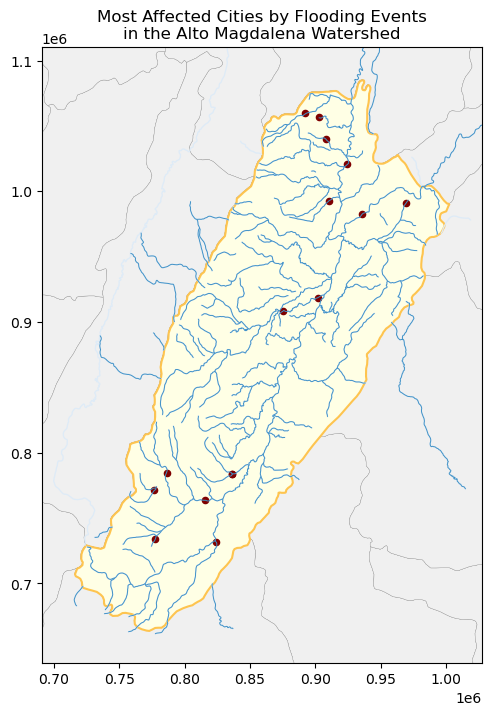

In [235]:
fig, ax = plt.subplots(figsize=(12, 8))
offset = 25000
ax.set_xlim(xmin - offset, xmax + offset)
ax.set_ylim(ymin - offset, ymax + offset)
watersheds_df.plot(ax=ax, facecolor='#f0f0f0', edgecolor='#737373', linewidth=0.2)
watershed.plot(ax=ax, facecolor='#ffffe5', edgecolor='#fec44f', linewidth=1.5)
buffers_region.plot(ax=ax, linewidth=0, facecolor='#deebf7')
rivers_region.plot(ax=ax, edgecolor='#4292c6', linewidth=0.7)
cities_watershed_max.plot(ax=ax, color='#7f0000', markersize=20)
watershed_name = watershed['CUENCA'].iloc[0]
ax.set_title(f'Most Affected Cities by Flooding Events\nin the {watershed_name} Watershed')
plt.show()

In [236]:
watershed_geom = watershed['geometry'].iloc[0]
type(watershed_geom)

shapely.geometry.polygon.Polygon

In [269]:
departments_watershed = departments_df[departments_df.intersects(watershed_geom)].copy()
departments_watershed['LABEL_COORDS'] = departments_watershed['geometry'].apply(lambda x: x.representative_point().coords[:])
departments_watershed['LABEL_COORDS'] = departments_watershed['LABEL_COORDS'].apply(lambda x: x[0])
departments_watershed.head()

,ID_ESPACIA,AREA_OFICI,NOMBRE_DPT,geometry,LABEL_COORDS
0,11,1605.0,BOGOTÁ,"POLYGON ((1000872.357 1025835.467, 1000893.001...","(989088.4288667843, 965294.4312427057)"
3,17,7888.0,CALDAS,"POLYGON ((934334.460 1129841.825, 934457.415 1...","(860348.4699305773, 1076883.8364026784)"
4,18,88965.0,CAQUETÁ,"POLYGON ((921349.237 815160.187, 921349.237 81...","(923066.4026857223, 614882.142340379)"
5,19,29308.0,CAUCA,"POLYGON ((736624.375 858870.298, 736688.570 85...","(689064.9989824321, 729007.0079187178)"
8,25,22605.0,CUNDINAMARCA,"POLYGON ((973702.156 1133176.932, 973796.135 1...","(1045126.2105705144, 1020545.8398061336)"


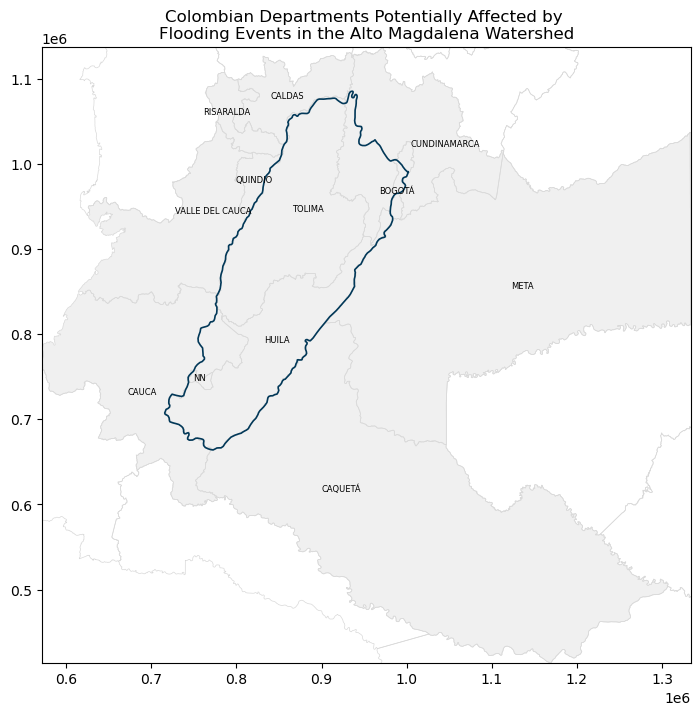

In [292]:
fig, ax = plt.subplots(figsize=(12, 8))

minx, miny, maxx, maxy = departments_watershed.total_bounds

ax.set_title(f'Colombian Departments Potentially Affected by \nFlooding Events in the {watershed_name} Watershed')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)


departments_watershed.plot(ax=ax, facecolor='#f0f0f0', edgecolor='none', linewidth=0.5)
departments_df.plot(ax=ax, facecolor='none', edgecolor='#d9d9d9', linewidth=0.5)
watershed.plot(ax=ax, facecolor='none', edgecolor='#023858', linewidth=1.2)

for idx, row in departments_watershed.iterrows():
  plt.annotate(text=row['NOMBRE_DPT'], xy=row['LABEL_COORDS'],\
               horizontalalignment='center', color='black', fontsize=6)

plt.show()


In [276]:
municipalities_watershed = municipalities_df[municipalities_df.intersects(watershed_geom)].copy()
municipalities_watershed.head(3)

,ID_ESPACIA,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,geometry
68,50370,6307.0,Cabecera Municipal,META,URIBE,50,"POLYGON ((1015933.340 772441.314, 1015932.748 ..."
74,50223,1159.0,Cabecera Municipal,META,CUBARRAL,50,"POLYGON ((1032149.608 903862.803, 1032133.148 ..."
282,25148,641.0,Cabecera Municipal,CUNDINAMARCA,CAPARRAPÍ,25,"POLYGON ((948755.943 1106152.036, 948821.053 1..."


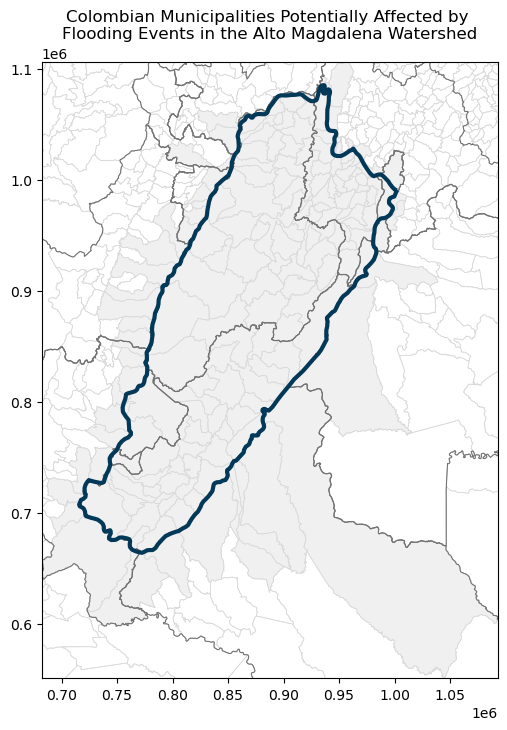

In [290]:
fig, ax = plt.subplots(figsize=(12, 8))

minx, miny, maxx, maxy = municipalities_watershed.total_bounds

ax.set_title(f'Colombian Municipalities Potentially Affected by \nFlooding Events in the {watershed_name} Watershed')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)



municipalities_watershed.plot(ax=ax, facecolor='#f0f0f0', edgecolor='none', linewidth=0.5)
municipalities_df.plot(ax=ax, facecolor='none', edgecolor='#d9d9d9', linewidth=0.5)
departments_watershed.plot(ax=ax, facecolor='none', edgecolor='#737373', linewidth=0.8)
watershed.plot(ax=ax, facecolor='none', edgecolor='#023858', linewidth=3)
plt.show()


In [293]:
rainfall_df.head()

,IDPRECIP,PRECIPITAC,RANGOPRECI,ANO,geometry
0,3,Seco,1001 - 2000 mm,2008,"POLYGON ((1023233.377 1370843.750, 1023060.374..."
1,3,Seco,1001 - 2000 mm,2008,"POLYGON ((835980.822 1604581.523, 835980.608 1..."
2,3,Seco,1001 - 2000 mm,2008,"POLYGON ((1375562.744 1277436.060, 1375654.898..."
3,3,Seco,1001 - 2000 mm,2008,"POLYGON ((1060551.252 1445885.751, 1060572.750..."
4,3,Seco,1001 - 2000 mm,2008,"POLYGON ((807839.667 1533013.386, 807831.058 1..."


#### Rainfall areas within the watershed with the most probability of floods 

In [322]:
rainfall_watershed = rainfall_df.clip(mask=watershed_geom).copy()
len(rainfall_watershed)

/Users/cristianmurillo/miniconda3/envs/geo/lib/python3.8/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


12

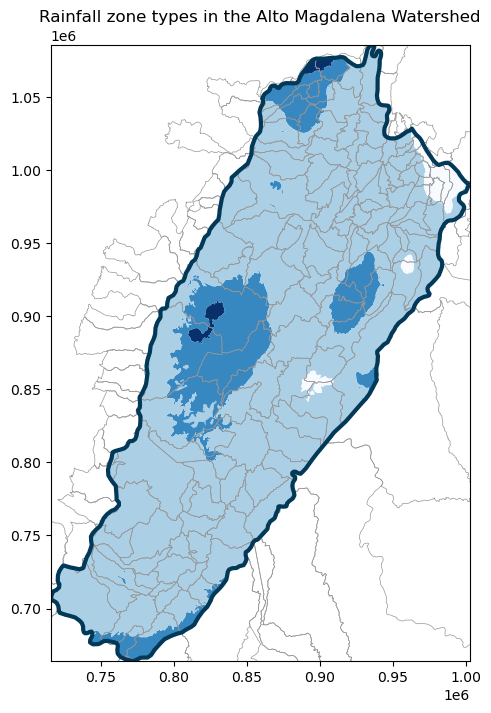

In [330]:
fig, ax = plt.subplots(figsize=(12, 8))

minx, miny, maxx, maxy = watershed.total_bounds

ax.set_title(f'Rainfall zone types in the {watershed_name} Watershed')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

rainfall_watershed.plot(ax=ax, edgecolor='none', column='IDPRECIP', cmap='Blues')
municipalities_watershed.plot(ax=ax, facecolor='none', edgecolor='#969696', linewidth=0.5)
watershed.plot(ax=ax, facecolor='none', edgecolor='#023858', linewidth=3)


plt.show()

In [324]:
rainfall_watershed['PRECIPITAC'].unique()

array(['Seco', 'Muy Húmedo', 'Húmedo', 'Muy Seco'], dtype=object)

In [331]:
rainfall_watershed_max = rainfall_watershed[rainfall_watershed['PRECIPITAC'].isin(['Muy Húmedo', 'Húmedo'])].copy()
rainfall_watershed_max.head()


,IDPRECIP,PRECIPITAC,RANGOPRECI,ANO,geometry
91,5,Muy Húmedo,3001 - 7000 mm,2008,"MULTIPOLYGON (((910343.310 1076574.249, 910314..."
90,4,Húmedo,2001 - 3000 mm,2008,"MULTIPOLYGON (((744201.748 681007.374, 744245...."


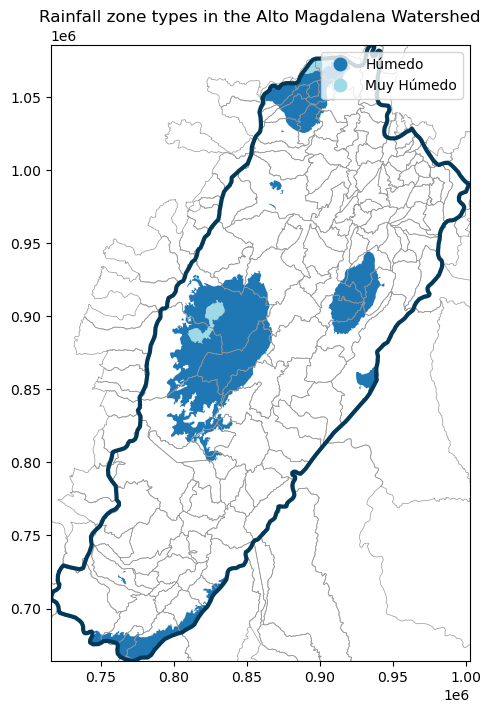

In [343]:
fig, ax = plt.subplots(figsize=(12, 8))

minx, miny, maxx, maxy = watershed.total_bounds

ax.set_title(f'Rainfall zone types in the {watershed_name} Watershed')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

rainfall_watershed_max.plot(ax=ax, edgecolor='none', column='PRECIPITAC', cmap='tab20', legend=True)
municipalities_watershed.plot(ax=ax, facecolor='none', edgecolor='#969696', linewidth=0.5)
watershed.plot(ax=ax, facecolor='none', edgecolor='#023858', linewidth=3)


plt.show()


In [345]:
municipalities_rainfall = municipalities_watershed.sjoin(rainfall_watershed_max, how='inner').copy()

municipalities_rainfall.head()


,ID_ESPACIA,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,geometry,index_right,IDPRECIP,PRECIPITAC,RANGOPRECI,ANO
68,50370,6307.0,Cabecera Municipal,META,URIBE,50,"POLYGON ((1015933.340 772441.314, 1015932.748 ...",90,4,Húmedo,2001 - 3000 mm,2008
288,25320,773.0,Cabecera Municipal,CUNDINAMARCA,GUADUAS,25,"POLYGON ((952058.446 1066868.883, 952130.266 1...",90,4,Húmedo,2001 - 3000 mm,2008
371,19533,1162.0,Cabecera Municipal,CAUCA,PIAMONTE,19,"POLYGON ((767295.471 667391.657, 767803.135 66...",90,4,Húmedo,2001 - 3000 mm,2008
377,19585,783.0,Cabecera Municipal,CAUCA,PURACÉ (Coconuco),19,"POLYGON ((744513.783 743981.203, 743731.418 74...",90,4,Húmedo,2001 - 3000 mm,2008
378,99999,0.0,ÁREA EN LITIGIO,NN,ÁREA EN LITIGIO,999,"POLYGON ((746336.945 757372.620, 746367.953 75...",90,4,Húmedo,2001 - 3000 mm,2008


In [346]:
len(municipalities_rainfall)

57

<AxesSubplot: >

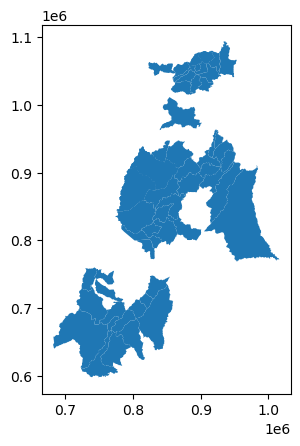

In [348]:
municipalities_rainfall.plot()

In [350]:
municipalities_rainfall = municipalities_rainfall[['ID_ESPACIA', 'AREA_OFICI', 'ENTIDAD_TE', 'NOM_DEPART', 'NOM_MUNICI',
                                                   'COD_DEPTO', 'geometry', 'index_right', 'IDPRECIP', 'PRECIPITAC']]

columns = {
  'index_right': 'RAINFALL_ID'
}
municipalities_rainfall = municipalities_rainfall.rename(columns=columns)
municipalities_rainfall.head()

,ID_ESPACIA,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,geometry,RAINFALL_ID,IDPRECIP,PRECIPITAC
68,50370,6307.0,Cabecera Municipal,META,URIBE,50,"POLYGON ((1015933.340 772441.314, 1015932.748 ...",90,4,Húmedo
288,25320,773.0,Cabecera Municipal,CUNDINAMARCA,GUADUAS,25,"POLYGON ((952058.446 1066868.883, 952130.266 1...",90,4,Húmedo
371,19533,1162.0,Cabecera Municipal,CAUCA,PIAMONTE,19,"POLYGON ((767295.471 667391.657, 767803.135 66...",90,4,Húmedo
377,19585,783.0,Cabecera Municipal,CAUCA,PURACÉ (Coconuco),19,"POLYGON ((744513.783 743981.203, 743731.418 74...",90,4,Húmedo
378,99999,0.0,ÁREA EN LITIGIO,NN,ÁREA EN LITIGIO,999,"POLYGON ((746336.945 757372.620, 746367.953 75...",90,4,Húmedo


In [371]:
def get_bounds_from_geodataframe(df: gpd.GeoDataFrame, offset: float = 0) -> tuple:
  xmin, ymin, xmax, ymax = df.total_bounds
  return (xmin - offset, xmax + offset, ymin - offset, ymax + offset)

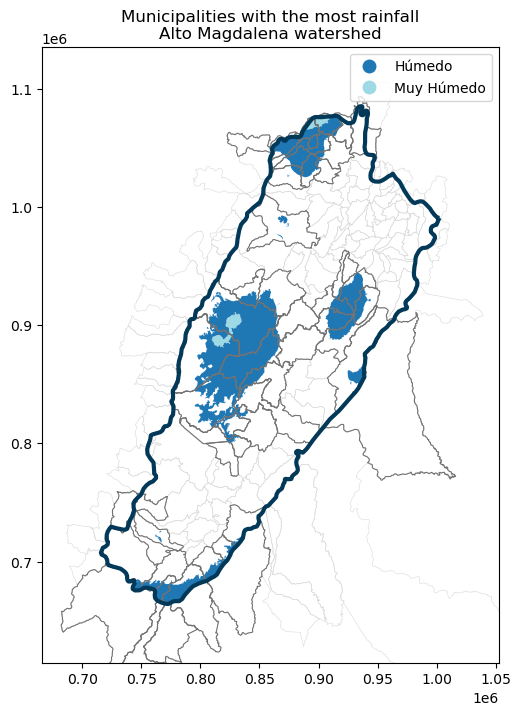

In [381]:
fig, ax = plt.subplots(figsize=(12, 8))

xmin, xmax, ymin, ymax = get_bounds_from_geodataframe(df=watershed, offset=50000)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title(f'Municipalities with the most rainfall\n{watershed_name} watershed')

municipalities_watershed.plot(ax=ax, facecolor='none', edgecolor='#d9d9d9', linewidth=0.4)
rainfall_watershed_max.plot(ax=ax, edgecolor='none', cmap='tab20', column='PRECIPITAC', legend=True)
municipalities_rainfall.plot(ax=ax, facecolor='none', edgecolor='#737373', linewidth=0.8)
watershed.plot(ax=ax, facecolor='none', edgecolor='#023858', linewidth=3)

plt.show()




In [386]:
municipalities_watershed.columns

Index(['ID_ESPACIA', 'AREA_OFICI', 'ENTIDAD_TE', 'NOM_DEPART', 'NOM_MUNICI',
       'COD_DEPTO', 'geometry'],
      dtype='object')

In [387]:
rivers_df.columns

Index(['ID_ST', 'NOMBRE', 'SHAPE_LEN', 'geometry', 'buffer_500'], dtype='object')

In [388]:
rivers_watershed = rivers_df.sjoin(municipalities_watershed, how='inner')
rivers_watershed = rivers_watershed.drop('buffer_500', axis=1)
rivers_watershed.head()

,ID_ST,NOMBRE,SHAPE_LEN,geometry,index_right,ID_ESPACIA,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO
93,940001506,RIO BOBO,31398.280932,"LINESTRING (764394.477 875119.658, 763911.933 ...",848,76563,369.0,Cabecera Municipal,VALLE DEL CAUCA,PRADERA,76
108,940001983,RIO PARRAGA,41605.710629,"LINESTRING (770351.838 865873.084, 769919.419 ...",848,76563,369.0,Cabecera Municipal,VALLE DEL CAUCA,PRADERA,76
109,940002000,RIO BOLO AZUL,33885.942453,"LINESTRING (780500.160 863276.071, 779689.439 ...",848,76563,369.0,Cabecera Municipal,VALLE DEL CAUCA,PRADERA,76
93,940001506,RIO BOBO,31398.280932,"LINESTRING (764394.477 875119.658, 763911.933 ...",412,76520,1044.0,Cabecera Municipal,VALLE DEL CAUCA,PALMIRA,76
100,940001592,RIO AMAIME,58109.661172,"LINESTRING (786244.510 905117.616, 786201.762 ...",412,76520,1044.0,Cabecera Municipal,VALLE DEL CAUCA,PALMIRA,76


In [389]:
rivers_watershed = rivers_watershed[['ID_ST', 'NOMBRE', 'SHAPE_LEN',
                                    'index_right', 'ID_ESPACIA', 'AREA_OFICI', 'geometry']]
rivers_watershed.head()


,ID_ST,NOMBRE,SHAPE_LEN,index_right,ID_ESPACIA,AREA_OFICI,geometry
93,940001506,RIO BOBO,31398.280932,848,76563,369.0,"LINESTRING (764394.477 875119.658, 763911.933 ..."
108,940001983,RIO PARRAGA,41605.710629,848,76563,369.0,"LINESTRING (770351.838 865873.084, 769919.419 ..."
109,940002000,RIO BOLO AZUL,33885.942453,848,76563,369.0,"LINESTRING (780500.160 863276.071, 779689.439 ..."
93,940001506,RIO BOBO,31398.280932,412,76520,1044.0,"LINESTRING (764394.477 875119.658, 763911.933 ..."
100,940001592,RIO AMAIME,58109.661172,412,76520,1044.0,"LINESTRING (786244.510 905117.616, 786201.762 ..."


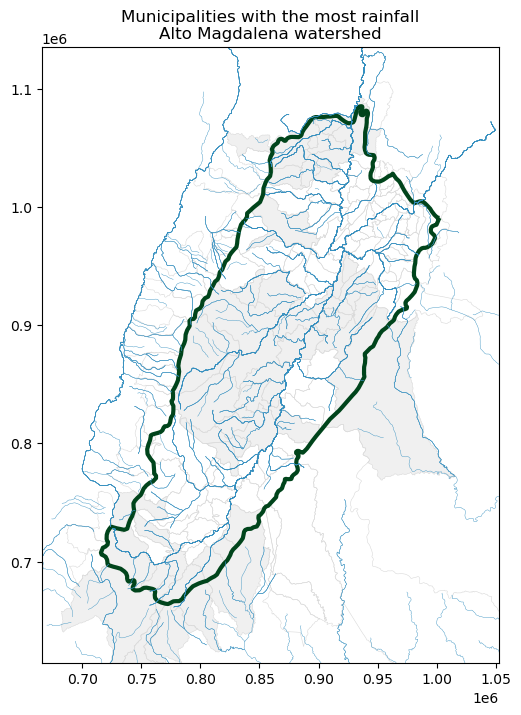

In [402]:
fig, ax = plt.subplots(figsize=(12, 8))

xmin, xmax, ymin, ymax = get_bounds_from_geodataframe(df=watershed, offset=50000)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title(f'Municipalities with the most rainfall\n{watershed_name} watershed')


municipalities_rainfall.plot(ax=ax, facecolor='#f0f0f0', edgecolor='none', linewidth=0.8)
municipalities_watershed.plot(ax=ax, facecolor='none', edgecolor='#d9d9d9', linewidth=0.4)
rivers_watershed.plot(ax=ax, edgecolor='#3690c0', linewidth=0.3)
watershed.plot(ax=ax, facecolor='none', edgecolor='#00441b', linewidth=3)

plt.show()


In [405]:
rivers_watershed = rivers_watershed.drop('index_right', axis=1)
rivers_watershed.head()

,ID_ST,NOMBRE,SHAPE_LEN,ID_ESPACIA,AREA_OFICI,geometry
93,940001506,RIO BOBO,31398.280932,76563,369.0,"LINESTRING (764394.477 875119.658, 763911.933 ..."
108,940001983,RIO PARRAGA,41605.710629,76563,369.0,"LINESTRING (770351.838 865873.084, 769919.419 ..."
109,940002000,RIO BOLO AZUL,33885.942453,76563,369.0,"LINESTRING (780500.160 863276.071, 779689.439 ..."
93,940001506,RIO BOBO,31398.280932,76520,1044.0,"LINESTRING (764394.477 875119.658, 763911.933 ..."
100,940001592,RIO AMAIME,58109.661172,76520,1044.0,"LINESTRING (786244.510 905117.616, 786201.762 ..."


In [406]:
rivers_max_rainfall = rivers_watershed.sjoin(rainfall_watershed_max)
rivers_max_rainfall.head()


,ID_ST,NOMBRE,SHAPE_LEN,ID_ESPACIA,AREA_OFICI,geometry,index_right,IDPRECIP,PRECIPITAC,RANGOPRECI,ANO
351,940008365,RIO AMOYA,87132.382426,73616,1136.0,"LINESTRING (796958.752 901730.919, 797188.119 ...",90,4,Húmedo,2001 - 3000 mm,2008
354,940008368,RIO ATA,73865.264958,73616,1136.0,"LINESTRING (786039.642 827546.102, 786523.873 ...",90,4,Húmedo,2001 - 3000 mm,2008
359,940008411,RIO CAMBRIN,24768.738394,73616,1136.0,"LINESTRING (794249.178 891095.596, 794425.923 ...",90,4,Húmedo,2001 - 3000 mm,2008
360,940008412,RIO ANAMICHU,33181.225551,73616,1136.0,"LINESTRING (795860.234 897806.276, 796545.274 ...",90,4,Húmedo,2001 - 3000 mm,2008
363,940008446,RIO BLANCO,33728.730374,73616,1136.0,"LINESTRING (810440.763 902347.246, 810768.939 ...",90,4,Húmedo,2001 - 3000 mm,2008


In [411]:
print(f'Total rivers in the watershed: {len(rivers_watershed)}\n\
Rivers in the areas with the highest rainfall: {len(rivers_max_rainfall)}')


Total rivers in the watershed: 520
Rivers in the areas with the highest rainfall: 170


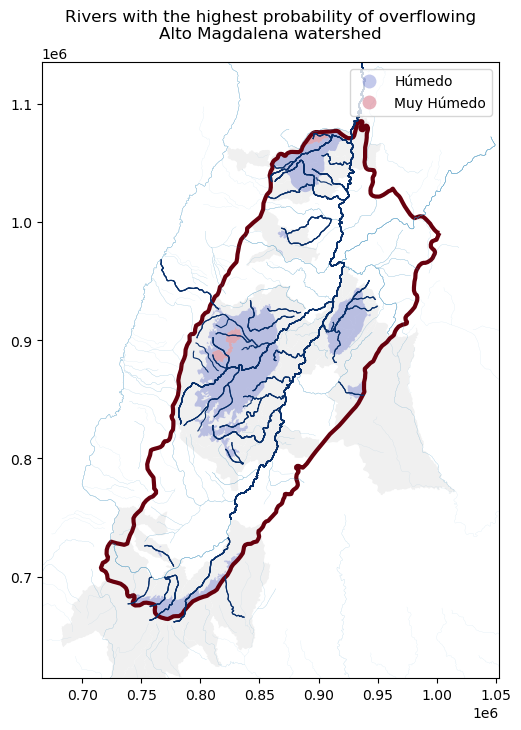

In [434]:
fig, ax = plt.subplots(figsize=(12, 8))

xmin, xmax, ymin, ymax = get_bounds_from_geodataframe(df=watershed, offset=50000)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title(f'Rivers with the highest probability of overflowing\n{watershed_name} watershed')


municipalities_rainfall.plot(ax=ax, facecolor='#f0f0f0', edgecolor='none', linewidth=0.8)
# municipalities_watershed.plot(ax=ax, facecolor='none', edgecolor='#d9d9d9', linewidth=0.4)
rainfall_watershed_max.plot(ax=ax, edgecolor='none', column='PRECIPITAC', cmap='coolwarm', legend=True, alpha=0.3)
rivers_watershed.plot(ax=ax, edgecolor='#3690c0', linewidth=0.2, alpha=0.2)
rivers_max_rainfall.plot(ax=ax, edgecolor='#08306b', linewidth=0.8)
watershed.plot(ax=ax, facecolor='none', edgecolor='#67000d', linewidth=3)

plt.show()


#### Selecting the Largest and Shortest Rivers in the Highest Rainfall Areas

In [435]:
rivers_max_rainfall['LENGTH'] = rivers_max_rainfall['geometry'].length

,ID_ST,NOMBRE,SHAPE_LEN,ID_ESPACIA,AREA_OFICI,geometry,index_right,IDPRECIP,PRECIPITAC,RANGOPRECI,ANO,LENGTH
351,940008365,RIO AMOYA,87132.382426,73616,1136.0,"LINESTRING (796958.752 901730.919, 797188.119 ...",90,4,Húmedo,2001 - 3000 mm,2008,87130.215253
354,940008368,RIO ATA,73865.264958,73616,1136.0,"LINESTRING (786039.642 827546.102, 786523.873 ...",90,4,Húmedo,2001 - 3000 mm,2008,73863.544318
359,940008411,RIO CAMBRIN,24768.738394,73616,1136.0,"LINESTRING (794249.178 891095.596, 794425.923 ...",90,4,Húmedo,2001 - 3000 mm,2008,24768.216316
360,940008412,RIO ANAMICHU,33181.225551,73616,1136.0,"LINESTRING (795860.234 897806.276, 796545.274 ...",90,4,Húmedo,2001 - 3000 mm,2008,33180.487853
363,940008446,RIO BLANCO,33728.730374,73616,1136.0,"LINESTRING (810440.763 902347.246, 810768.939 ...",90,4,Húmedo,2001 - 3000 mm,2008,33728.061330


In [439]:
# largest river
largest_river = rivers_max_rainfall.sort_values(by='LENGTH', ascending=False).iloc[0]
# shortest
shortest_river = rivers_max_rainfall.sort_values(by='LENGTH', ascending=True).iloc[0]


In [443]:
shortest_river_name = shortest_river['NOMBRE']
shortest_river_length = shortest_river['LENGTH'] / 1000

largest_river_name = largest_river['NOMBRE']
largest_river_length = largest_river['LENGTH'] / 1000

print(f'The shortest river in the areas with the most rainfall is the {shortest_river_name} with a length of {shortest_river_length} Km.')
print(
    f'The largest river in the areas with the most rainfall is the {largest_river_name} with a length of {largest_river_length} Km.')


The shortest river in the areas with the most rainfall is the RIO CACHICHI with a length of 13.710198925036128 Km.
The largest river in the areas with the most rainfall is the RIO MAGDALENA with a length of 1320.9471549440732 Km.
